# ________________________________________
# Tarefa 3 - Implementação da fase forward MLP
# ________________________________________

In [2]:
import numpy as np
import pandas as pd
import sklearn as sklearn
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import random

DEBUG = 'DEBUG'

np.__version__,pd.__version__,sklearn.__version__

('1.21.5', '1.4.1', '1.0.2')

In [3]:
def criaDataset(n=20,slop=[2,1],intercept=-0.4):
  X = np.random.uniform(size=(n,2))
  AUX = np.multiply(X,slop) - [0,intercept]
  y = (AUX[:,0] > AUX[:,1])*2 -1
  return X,y

def criaDatasetBlobs(n=1000,n_classes=4,std=0.02):
  X,y = make_blobs(n_samples=n,centers=n_classes,center_box=(0,1.0),cluster_std=0.02)
  return X,y

def criaDatasetXOR(n=100):
  X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
  y =np.array(y%2,dtype=int)
  return X,y

def criaDatasetNBlobsXOR(n=1000,n_classes=3,std=0.8):
  X,y = make_blobs(n_samples=n,centers=n_classes*2,cluster_std=std)
  y = np.array(y%n_classes,dtype=int)
  return X,y

def plotDataset(X,y):
  plt.xlabel('X1')
  plt.ylabel('X2')
  for k in set(y):
    plt.plot(X[:,0][y==k],
             X[:,1][y==k],
             "o",alpha=0.3)

In [4]:
def define_axes(X,margin=0.1):
  min1,max1 = X[:,0].min(), X[:,0].max()
  min2,max2 = X[:,1].min(), X[:,1].max()
  return [min1 -margin, max1 +margin,min2 -margin,max2 +margin]

    

def plotPredictions(clf,X,dims=[0,1]):
  axes = define_axes(X)
  x0s = np.linspace(axes[0],axes[1],100)
  x1s = np.linspace(axes[2],axes[3],100)
  x0,x1 = np.meshgrid(x0s,x1s)
  X_ = np.c_[x0.ravel(),x1.ravel()]
  print(DEBUG,X_.shape)
  ypred = clf.predict(X_).reshape(x0.shape)
  print(DEBUG,X_.shape,x0.shape,x1.shape,ypred.shape)
  plt.contourf(x0,x1,ypred,cmap=plt.cm.brg,alpha=0.2)

In [84]:
from abc import ABC, abstractmethod,abstractstaticmethod
from scipy.special import expit
from sklearn.preprocessing import label_binarize

def sign(a):
  return (a>=0)*2-1

def tanh(a):
  return expit(a)*2 -1

#tanh = lambda a: expit(a)*2 -1

def accuracy(yactual,ypred):
  return sum(yactual==ypred)/len(yactual)


class TrainingAlgorithm(ABC):
  
  @abstractmethod
  def getW(self,X,y):
    pass

class PseudoInversaReg(TrainingAlgorithm):
  def __init__(self,regularization=0,history=[0]):
    self.history = history
    self.regularization = regularization
    
  def getW(self,X,y):
    w = np.linalg.inv(X.T @ X + np.identity(X.shape[1])*self.regularization) @ X.T @ y
    return w

class ELM(BaseEstimator,ClassifierMixin):
  def __init__ (self,n_hidden=10,regularization=0):
    self.n_hidden=n_hidden
    self.regularization = regularization
    self.activation = tanh
    self.training_algorithm = PseudoInversaReg(regularization=regularization)
    self.wih = None
    self.who = None
  
  def encode_labels(self,y):
    self.labels = list(set(y))
    return label_binarize(y,classes=self.labels)*2 -1
  
  def fit(self,X,y):
    Xb = ELM.includeBias(X)
    self.wih = np.random.uniform(-1,1,size=(Xb.shape[1],self.n_hidden)) #-1 a 1 com threshold em 0
    print(DEBUG,  Xb.shape, self.wih.shape)
    H = self.activation(Xb @ self.wih)
    Hb = ELM.includeBias(H)
    #yhot = self.encode_labels(y)
    self.who = self.training_algorithm.getW(Hb,y)#yhot)  

    return self
  
  def predict(self,X,y=None):
    Xb = ELM.includeBias(X)
    print(DEBUG,  Xb.shape, self.wih.shape)
    H = self.activation(Xb @ self.wih)
    Hb = ELM.includeBias(H)
    a = Hb @ self.who
    return a
    

  @staticmethod
  def includeBias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb

class FixedWeigths():
  def __init__(self):
    self.n_hidden = 2
    self.activation = tanh
    self.training = PseudoInversaReg()
  
  def fit(self,X,y):
    # Definição manual de pesos
    self.wih = np.array([[1,0.9,-0.9],[-1,0.9,-0.9]]).T
    self.who = np.array([[ 11,-13, 12]]).T

    # Treino somenete da ultima camanda
    #H = self.activation(FixedWeigths.includeBias(X) @ self.wih)
    #Hb = FixedWeigths.includeBias(H) 
    #self.who = self.training.getW(Hb,y)
    #print(DEBUG,self.who)
    return self
  
  def predict(self,X,y=None):
    Xb = FixedWeigths.includeBias(X)
    H = self.activation(Xb @ self.wih)
    Hb = FixedWeigths.includeBias(H)
    return Hb @ self.who
  
  @staticmethod
  def includeBias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb

class MLP(BaseEstimator,ClassifierMixin):
  def __init__ (self,algorithm=FixedWeigths()):
    self.algorithm = algorithm
  
  def encode_labels(self,y):
    self.labels = list(set(y))
    return label_binarize(y,classes=self.labels)*2 -1
  
  def fit(self,X,y):
    yhot = self.encode_labels(y)
    self.algorithm.fit(X,yhot)
    return self
  
  def predict(self,X,y=None):
    a = self.algorithm.predict(X,y)
    
    if len(self.labels) <= 2:
      idx = np.array(a>0,dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a,axis=1)

    ypred = np.array([self.labels[i] for i in idx])
    return ypred  


In [85]:
Xtr,ytr = criaDatasetXOR(4)

DEBUG (10000, 2)
DEBUG (10000, 2) (100, 100) (100, 100) (100, 100)


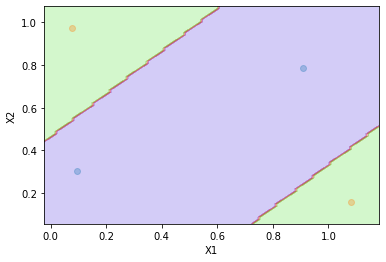

In [86]:

clf = MLP(algorithm=FixedWeigths())
clf.fit(Xtr,ytr)


plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr)

DEBUG (10000, 2)
DEBUG (10000, 2) (100, 100) (100, 100) (100, 100)


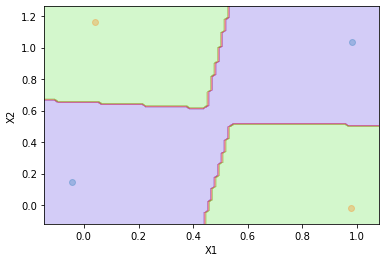

In [75]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(Xtr,ytr)


plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr)